In [1]:
%config IPCompleter.use_jedi = False

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD, Dataset, BaselineOnly
from surprise.model_selection import cross_validate
from surprise import Reader

In [3]:
#book_data30 = pd.read_csv("top30tags/book_data.csv")
#book_data10 = pd.read_csv("top10tags/book_data.csv")
#book_data10_filter = pd.read_csv("top10tags/book_data_filter.csv")
#book_data10_filter_binary = pd.read_csv("top10tags/book_data_filter_binary.csv")
book_data = pd.read_csv("toptags10/book_data.csv")
book_data_binary = pd.read_csv("toptags10/book_data_binary.csv")
book_data_log = pd.read_csv("toptags10/book_data_log.csv")
book = pd.read_csv("goodbooks-10k/books.csv")
ratings = pd.read_csv("goodbooks-10k/ratings.csv")

book_data = (
    book
    .filter(items=["goodreads_book_id", "ratings_count"])
    .merge(book_data, on="goodreads_book_id")
    .assign(log_ratings_count=lambda x: np.log(x["ratings_count"]))
    .drop(columns=["ratings_count"])
)

In [4]:
book_data_log

,book_id,goodreads_book_id,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
0,1,2767052,0.000000,0.0,0.000000,0.000000,4.034909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.524006,0.0,3.727433,4.264735
1,2,3,0.000000,0.0,3.371945,3.070038,4.676502,0.000000,0.000000,0.000000,2.818226,0.000000,2.965672,0.000000,0.0,0.000000,4.005652
2,3,41865,0.000000,0.0,0.000000,0.000000,4.155002,0.000000,0.000000,0.000000,0.000000,0.000000,3.714414,0.000000,0.0,2.390051,4.060339
3,4,2657,0.000000,0.0,0.000000,4.271598,0.000000,3.484229,0.000000,0.000000,2.392697,0.000000,0.000000,0.000000,0.0,0.000000,3.199206
4,5,4671,0.000000,0.0,0.000000,4.275599,0.000000,3.217879,0.000000,0.000000,0.000000,0.000000,0.000000,3.320354,0.0,0.000000,2.599883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,9996,7130616,0.000000,0.0,0.000000,0.000000,2.900367,0.000000,0.000000,0.000000,1.204120,0.000000,2.655138,2.667453,0.0,1.176091,0.000000
9955,9997,208324,2.491362,0.0,0.000000,0.602060,0.000000,0.778151,0.000000,0.000000,0.000000,1.903090,0.000000,0.000000,0.0,0.000000,0.000000
9956,9998,77431,0.000000,0.0,0.000000,1.079181,0.000000,2.537189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9957,9999,8565083,0.000000,0.0,0.845098,0.000000,0.000000,0.000000,1.041393,1.243038,0.000000,2.812245,0.000000,0.000000,0.0,0.000000,0.000000


# Train Test Split

- For the Many Models, we include users who have at least 150 ratings.
- We split a user's ratings into train/test with 0.2 ratings going into test.

Each user rates a book once.

In [5]:
min_number_of_ratings_required = 150

topuserids = (
    ratings
    .groupby("user_id", as_index=False)
    .count()
    .sort_values("rating", ascending=False)
    .query("rating >= @min_number_of_ratings_required")
    .user_id
    .to_list()
)

top_user_ratings = (
    ratings
    .query("user_id in @topuserids")
    .merge(book_data_log, on="book_id")
    .drop(columns=["book_id", "goodreads_book_id"])
)

In [6]:
train, test = train_test_split(
    top_user_ratings, test_size=.2, stratify=top_user_ratings.user_id, random_state=0
)

In [7]:
def train_single_user_model(df):
    y = df.rating
    X = df.drop(columns=["rating", "user_id"])
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error")
    return scores

In [8]:
def train_single_user_base_model(df):
    y = df.rating
    X = np.ones(y.shape).reshape(-1,1)
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error", )
    return scores

In [ ]:
-train_single_user_base_model(user_ratings)

# Model with 1  "top" user

user_id: 30944

number_ratings: 200

In [9]:
TOP_USER = 30944

In [10]:
def get_data_for_user(user_id, df):
    return df.query("user_id == @user_id")

In [11]:
get_data_for_user(TOP_USER, top_user_ratings).head(5)

,user_id,rating,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
4751,30944,5,0.0,0.0,0.000000,2.128722,2.361728,0.000000,0.0,0.0,0.000000,0.0,2.029384,2.103804,0.0,1.916454,2.051153
5800,30944,5,0.0,0.0,0.000000,3.858417,0.000000,3.123525,0.0,0.0,0.000000,0.0,0.000000,2.588832,0.0,0.000000,0.000000
11654,30944,4,0.0,0.0,3.252428,3.037825,4.594735,0.000000,0.0,0.0,2.721811,0.0,2.857935,0.000000,0.0,0.000000,3.933386
15523,30944,5,0.0,0.0,3.273522,2.850646,4.596619,0.000000,0.0,0.0,2.780317,0.0,2.865104,0.000000,0.0,0.000000,3.927704
17709,30944,4,0.0,0.0,0.000000,2.867467,3.303844,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.555094


In [72]:
user_ratings = get_data_for_user(TOP_USER, top_user_ratings)
scores = -train_single_user_model(user_ratings)
scores.mean()

0.7802946162138371

In [78]:
model = LinearRegression()
y=user_ratings.rating
X=user_ratings.drop(columns=["rating", "user_id"])
scores = cross_val_score(model, X, y, cv=5, scoring="neg_root_mean_squared_error")

In [79]:
-scores.mean()

0.7802946162138371

In [92]:
-cross_val_score(model, X, y, cv=5).mean()

0.14463261784727538

In [80]:
model_sk = model.fit(X,y)

In [81]:
model_sk.score(X,y)

0.16829385874137703

In [82]:
np.mean((model_sk.predict(X) - y)**2)**.5

0.692083496950217

In [18]:
df = get_data_for_user(TOP_USER, df=top_user_ratings)
y=df.rating
X=sm.add_constant(df.drop(columns=["rating", "user_id"]))
model_sm = sm.OLS(y,X).fit()

In [19]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.482
Date:                Fri, 30 Apr 2021   Prob (F-statistic):            0.00240
Time:                        12:28:04   Log-Likelihood:                -210.18
No. Observations:                 200   AIC:                             452.4
Df Residuals:                     184   BIC:                             505.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9400      0.205     19.180      0.000       3.535       4.345
biography             -0.2635      0.273     -0.967      0.335      -0.801       0.274
business              -0.2189      0.325     -0.673      0.502      -0.860       0.423
childrens             -0.0773      0.067     -1.151      0.251      -0.210       0.055
classics               0.0630      0.050      1.258      0.210      -0.036       0.162
fantasy                0.1167      0.054      2.164      0.032       0.010       0.223
historical-fiction    -0.1248      0.064     -1.955      0.052      -0.251       0.001
humor                  0.0923      0.058      1.587      0.114      -0.022       0.207
memoir                 0.3256      0.302      1.077      0.283      -0.271       0.922
mystery                0.0308      0.068      0.451      0.652      -0.104       0.165
non-fiction            0.1499      0.114      1.316      0.190      -0.075       0.374
paranormal            -0.1834      0.075     -2.456      0.015      -0.331      -0.036
romance                0.0126      0.056      0.226      0.821      -0.097       0.123
science               -0.0506      0.128     -0.395      0.693      -0.303       0.202
science-fiction        0.0580      0.071      0.814      0.417      -0.083       0.199
young-adult            0.0097      0.059      0.163      0.871      -0.107       0.127
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.386
Skew:                          -0.423   Prob(JB):                       0.0411
Kurtosis:                       2.774   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

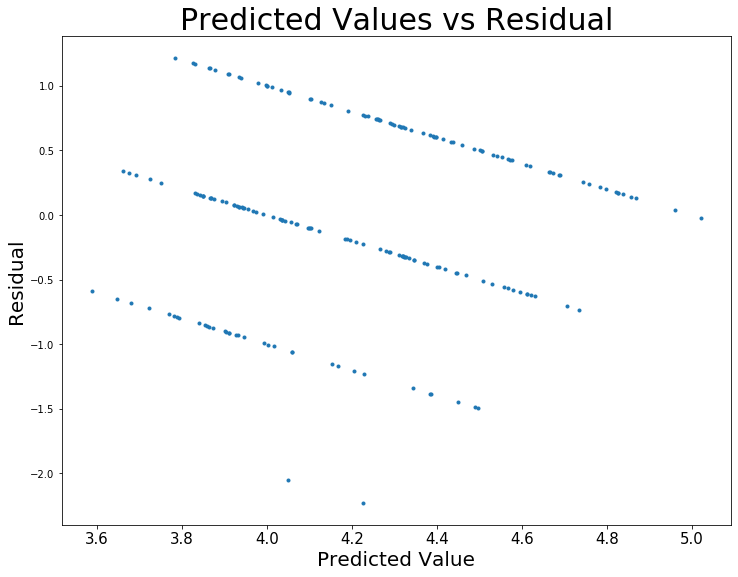

In [20]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(model_sm.predict(X), y-model_sm.predict(X), ".")
labels = ax.get_xticklabels()
plt.setp(labels, fontsize=15)
plt.title("Predicted Values vs Residual", fontsize=30)
plt.xlabel("Predicted Value", fontsize=20)
plt.ylabel("Residual", fontsize=20)
plt.savefig("plots/single_user_model_pred_vs_resid.png", bbox_inches="tight")

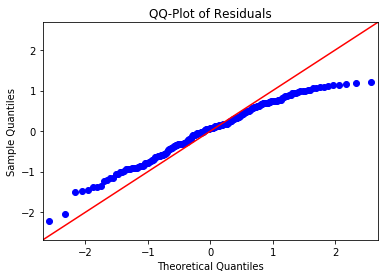

In [21]:
sm.qqplot(model_sm.resid, line="45")
plt.title("QQ-Plot of Residuals")
plt.savefig("plots/qqplot.png")

In [22]:
user_ratings

,user_id,rating,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
4751,30944,5,0.0,0.0,0.000000,2.128722,2.361728,0.000000,0.0,0.0,0.000000,0.0,2.029384,2.103804,0.0,1.916454,2.051153
5800,30944,5,0.0,0.0,0.000000,3.858417,0.000000,3.123525,0.0,0.0,0.000000,0.0,0.000000,2.588832,0.0,0.000000,0.000000
11654,30944,4,0.0,0.0,3.252428,3.037825,4.594735,0.000000,0.0,0.0,2.721811,0.0,2.857935,0.000000,0.0,0.000000,3.933386
15523,30944,5,0.0,0.0,3.273522,2.850646,4.596619,0.000000,0.0,0.0,2.780317,0.0,2.865104,0.000000,0.0,0.000000,3.927704
17709,30944,4,0.0,0.0,0.000000,2.867467,3.303844,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.555094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571412,30944,5,0.0,0.0,0.000000,0.000000,3.904283,0.000000,0.0,0.0,0.000000,0.0,0.000000,3.396548,0.0,3.601227,4.172194
579153,30944,5,0.0,0.0,0.942008,0.000000,2.264818,0.602060,0.0,0.0,0.000000,0.0,0.954243,0.845098,0.0,0.000000,1.752048
599274,30944,4,0.0,0.0,0.000000,0.000000,4.097292,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.845098,0.0,1.883661,1.707570
603715,30944,4,0.0,0.0,1.607455,0.000000,3.810031,0.000000,0.0,0.0,0.000000,0.0,1.681241,1.857332,0.0,1.676694,3.019739


# Single Model with standardized data

In [23]:
user_ratings = get_data_for_user(TOP_USER, top_user_ratings)
y = user_ratings.rating
X = user_ratings.drop(columns=["rating", "user_id"])
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

model = LinearRegression().fit(X_scaled, y)
model.score(X_scaled, y)

0.16829385874137692

In [24]:
X

,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
4751,0.0,0.0,0.000000,2.128722,2.361728,0.000000,0.0,0.0,0.000000,0.0,2.029384,2.103804,0.0,1.916454,2.051153
5800,0.0,0.0,0.000000,3.858417,0.000000,3.123525,0.0,0.0,0.000000,0.0,0.000000,2.588832,0.0,0.000000,0.000000
11654,0.0,0.0,3.252428,3.037825,4.594735,0.000000,0.0,0.0,2.721811,0.0,2.857935,0.000000,0.0,0.000000,3.933386
15523,0.0,0.0,3.273522,2.850646,4.596619,0.000000,0.0,0.0,2.780317,0.0,2.865104,0.000000,0.0,0.000000,3.927704
17709,0.0,0.0,0.000000,2.867467,3.303844,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.555094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571412,0.0,0.0,0.000000,0.000000,3.904283,0.000000,0.0,0.0,0.000000,0.0,0.000000,3.396548,0.0,3.601227,4.172194
579153,0.0,0.0,0.942008,0.000000,2.264818,0.602060,0.0,0.0,0.000000,0.0,0.954243,0.845098,0.0,0.000000,1.752048
599274,0.0,0.0,0.000000,0.000000,4.097292,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.845098,0.0,1.883661,1.707570
603715,0.0,0.0,1.607455,0.000000,3.810031,0.000000,0.0,0.0,0.000000,0.0,1.681241,1.857332,0.0,1.676694,3.019739


In [25]:
X_scaled

array([[-0.15859744, -0.09969288, -0.70637092, ..., -0.29777383,
         0.80862493,  0.41638463],
       [-0.15859744, -0.09969288, -0.70637092, ..., -0.29777383,
        -0.81673848, -1.12358851],
       [-0.15859744, -0.09969288,  1.80143437, ..., -0.29777383,
        -0.81673848,  1.82953604],
       ...,
       [-0.15859744, -0.09969288, -0.70637092, ..., -0.29777383,
         0.78081328,  0.1584284 ],
       [-0.15859744, -0.09969288,  0.5330674 , ..., -0.29777383,
         0.60528183,  1.14358434],
       [-0.15859744, -0.09969288, -0.70637092, ..., -0.29777383,
         1.10407575,  0.9232895 ]])

# Lasso

In [83]:
model_lasso = LassoCV().fit(X,y)
np.mean(-cross_val_score(model_lasso, X, y, cv=5, scoring="neg_root_mean_squared_error"))

0.7739532618630507

In [86]:
np.mean(-cross_val_score(model_lasso, X, y, cv=5))

0.11424712900006177

In [28]:
for coef, val in zip(X.columns, model_lasso.coef_):
    print(f"{coef}: {val}")

biography: 0.0
business: -0.0
childrens: -0.013677389342564749
classics: 0.0
fantasy: 0.06680048285131952
historical-fiction: -0.060939346601791705
humor: 0.028396280886363718
memoir: 0.0
mystery: -0.0
non-fiction: 0.0
paranormal: -0.11112100745261533
romance: -0.0
science: 0.0
science-fiction: 0.027434442911828765
young-adult: -0.0


In [27]:
model_lasso.alpha_

0.05906058391967991

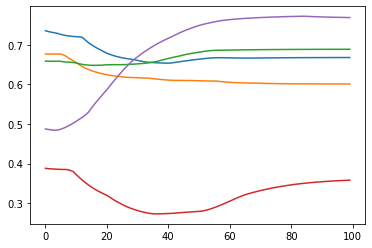

In [29]:
plt.plot(model_lasso.mse_path_)
plt.show()

# Base model

In [85]:
model_base = train_single_user_base_model(user_ratings)
-model_base.mean()

0.7637794980186929

In [91]:
model_base = LinearRegression().fit(X = np.ones(y.shape).reshape(-1,1),y=y)
np.mean(-cross_val_score(model_base, X=np.ones(y.shape).reshape(-1,1), y=y, cv=5))

0.07492070006580401

# Many Models

In [31]:
unique_users = top_user_ratings.user_id.unique().tolist()
n = len(unique_users)
all_rmse = []
all_base_rmse = []
ind=1
for user in unique_users:
    print(f"Training {ind} of {n}")
    ind+=1
    user_ratings = get_data_for_user(user, top_user_ratings)
    scores = -train_single_user_model(user_ratings)
    all_rmse.append(scores.mean())
    all_base_rmse.append(-train_single_user_base_model(user_ratings).mean())

Training 1 of 4235
Training 2 of 4235
Training 3 of 4235
Training 4 of 4235
Training 5 of 4235
Training 6 of 4235
Training 7 of 4235
Training 8 of 4235
Training 9 of 4235
Training 10 of 4235
Training 11 of 4235
Training 12 of 4235
Training 13 of 4235
Training 14 of 4235
Training 15 of 4235
Training 16 of 4235
Training 17 of 4235
Training 18 of 4235
Training 19 of 4235
Training 20 of 4235
Training 21 of 4235
Training 22 of 4235
Training 23 of 4235
Training 24 of 4235
Training 25 of 4235
Training 26 of 4235
Training 27 of 4235
Training 28 of 4235
Training 29 of 4235
Training 30 of 4235
Training 31 of 4235
Training 32 of 4235
Training 33 of 4235
Training 34 of 4235
Training 35 of 4235
Training 36 of 4235
Training 37 of 4235
Training 38 of 4235
Training 39 of 4235
Training 40 of 4235
Training 41 of 4235
Training 42 of 4235
Training 43 of 4235
Training 44 of 4235
Training 45 of 4235
Training 46 of 4235
Training 47 of 4235
Training 48 of 4235
Training 49 of 4235
Training 50 of 4235
Training 

Training 397 of 4235
Training 398 of 4235
Training 399 of 4235
Training 400 of 4235
Training 401 of 4235
Training 402 of 4235
Training 403 of 4235
Training 404 of 4235
Training 405 of 4235
Training 406 of 4235
Training 407 of 4235
Training 408 of 4235
Training 409 of 4235
Training 410 of 4235
Training 411 of 4235
Training 412 of 4235
Training 413 of 4235
Training 414 of 4235
Training 415 of 4235
Training 416 of 4235
Training 417 of 4235
Training 418 of 4235
Training 419 of 4235
Training 420 of 4235
Training 421 of 4235
Training 422 of 4235
Training 423 of 4235
Training 424 of 4235
Training 425 of 4235
Training 426 of 4235
Training 427 of 4235
Training 428 of 4235
Training 429 of 4235
Training 430 of 4235
Training 431 of 4235
Training 432 of 4235
Training 433 of 4235
Training 434 of 4235
Training 435 of 4235
Training 436 of 4235
Training 437 of 4235
Training 438 of 4235
Training 439 of 4235
Training 440 of 4235
Training 441 of 4235
Training 442 of 4235
Training 443 of 4235
Training 444 

Training 788 of 4235
Training 789 of 4235
Training 790 of 4235
Training 791 of 4235
Training 792 of 4235
Training 793 of 4235
Training 794 of 4235
Training 795 of 4235
Training 796 of 4235
Training 797 of 4235
Training 798 of 4235
Training 799 of 4235
Training 800 of 4235
Training 801 of 4235
Training 802 of 4235
Training 803 of 4235
Training 804 of 4235
Training 805 of 4235
Training 806 of 4235
Training 807 of 4235
Training 808 of 4235
Training 809 of 4235
Training 810 of 4235
Training 811 of 4235
Training 812 of 4235
Training 813 of 4235
Training 814 of 4235
Training 815 of 4235
Training 816 of 4235
Training 817 of 4235
Training 818 of 4235
Training 819 of 4235
Training 820 of 4235
Training 821 of 4235
Training 822 of 4235
Training 823 of 4235
Training 824 of 4235
Training 825 of 4235
Training 826 of 4235
Training 827 of 4235
Training 828 of 4235
Training 829 of 4235
Training 830 of 4235
Training 831 of 4235
Training 832 of 4235
Training 833 of 4235
Training 834 of 4235
Training 835 

Training 1171 of 4235
Training 1172 of 4235
Training 1173 of 4235
Training 1174 of 4235
Training 1175 of 4235
Training 1176 of 4235
Training 1177 of 4235
Training 1178 of 4235
Training 1179 of 4235
Training 1180 of 4235
Training 1181 of 4235
Training 1182 of 4235
Training 1183 of 4235
Training 1184 of 4235
Training 1185 of 4235
Training 1186 of 4235
Training 1187 of 4235
Training 1188 of 4235
Training 1189 of 4235
Training 1190 of 4235
Training 1191 of 4235
Training 1192 of 4235
Training 1193 of 4235
Training 1194 of 4235
Training 1195 of 4235
Training 1196 of 4235
Training 1197 of 4235
Training 1198 of 4235
Training 1199 of 4235
Training 1200 of 4235
Training 1201 of 4235
Training 1202 of 4235
Training 1203 of 4235
Training 1204 of 4235
Training 1205 of 4235
Training 1206 of 4235
Training 1207 of 4235
Training 1208 of 4235
Training 1209 of 4235
Training 1210 of 4235
Training 1211 of 4235
Training 1212 of 4235
Training 1213 of 4235
Training 1214 of 4235
Training 1215 of 4235
Training 1

Training 1547 of 4235
Training 1548 of 4235
Training 1549 of 4235
Training 1550 of 4235
Training 1551 of 4235
Training 1552 of 4235
Training 1553 of 4235
Training 1554 of 4235
Training 1555 of 4235
Training 1556 of 4235
Training 1557 of 4235
Training 1558 of 4235
Training 1559 of 4235
Training 1560 of 4235
Training 1561 of 4235
Training 1562 of 4235
Training 1563 of 4235
Training 1564 of 4235
Training 1565 of 4235
Training 1566 of 4235
Training 1567 of 4235
Training 1568 of 4235
Training 1569 of 4235
Training 1570 of 4235
Training 1571 of 4235
Training 1572 of 4235
Training 1573 of 4235
Training 1574 of 4235
Training 1575 of 4235
Training 1576 of 4235
Training 1577 of 4235
Training 1578 of 4235
Training 1579 of 4235
Training 1580 of 4235
Training 1581 of 4235
Training 1582 of 4235
Training 1583 of 4235
Training 1584 of 4235
Training 1585 of 4235
Training 1586 of 4235
Training 1587 of 4235
Training 1588 of 4235
Training 1589 of 4235
Training 1590 of 4235
Training 1591 of 4235
Training 1

Training 1921 of 4235
Training 1922 of 4235
Training 1923 of 4235
Training 1924 of 4235
Training 1925 of 4235
Training 1926 of 4235
Training 1927 of 4235
Training 1928 of 4235
Training 1929 of 4235
Training 1930 of 4235
Training 1931 of 4235
Training 1932 of 4235
Training 1933 of 4235
Training 1934 of 4235
Training 1935 of 4235
Training 1936 of 4235
Training 1937 of 4235
Training 1938 of 4235
Training 1939 of 4235
Training 1940 of 4235
Training 1941 of 4235
Training 1942 of 4235
Training 1943 of 4235
Training 1944 of 4235
Training 1945 of 4235
Training 1946 of 4235
Training 1947 of 4235
Training 1948 of 4235
Training 1949 of 4235
Training 1950 of 4235
Training 1951 of 4235
Training 1952 of 4235
Training 1953 of 4235
Training 1954 of 4235
Training 1955 of 4235
Training 1956 of 4235
Training 1957 of 4235
Training 1958 of 4235
Training 1959 of 4235
Training 1960 of 4235
Training 1961 of 4235
Training 1962 of 4235
Training 1963 of 4235
Training 1964 of 4235
Training 1965 of 4235
Training 1

Training 2297 of 4235
Training 2298 of 4235
Training 2299 of 4235
Training 2300 of 4235
Training 2301 of 4235
Training 2302 of 4235
Training 2303 of 4235
Training 2304 of 4235
Training 2305 of 4235
Training 2306 of 4235
Training 2307 of 4235
Training 2308 of 4235
Training 2309 of 4235
Training 2310 of 4235
Training 2311 of 4235
Training 2312 of 4235
Training 2313 of 4235
Training 2314 of 4235
Training 2315 of 4235
Training 2316 of 4235
Training 2317 of 4235
Training 2318 of 4235
Training 2319 of 4235
Training 2320 of 4235
Training 2321 of 4235
Training 2322 of 4235
Training 2323 of 4235
Training 2324 of 4235
Training 2325 of 4235
Training 2326 of 4235
Training 2327 of 4235
Training 2328 of 4235
Training 2329 of 4235
Training 2330 of 4235
Training 2331 of 4235
Training 2332 of 4235
Training 2333 of 4235
Training 2334 of 4235
Training 2335 of 4235
Training 2336 of 4235
Training 2337 of 4235
Training 2338 of 4235
Training 2339 of 4235
Training 2340 of 4235
Training 2341 of 4235
Training 2

Training 2672 of 4235
Training 2673 of 4235
Training 2674 of 4235
Training 2675 of 4235
Training 2676 of 4235
Training 2677 of 4235
Training 2678 of 4235
Training 2679 of 4235
Training 2680 of 4235
Training 2681 of 4235
Training 2682 of 4235
Training 2683 of 4235
Training 2684 of 4235
Training 2685 of 4235
Training 2686 of 4235
Training 2687 of 4235
Training 2688 of 4235
Training 2689 of 4235
Training 2690 of 4235
Training 2691 of 4235
Training 2692 of 4235
Training 2693 of 4235
Training 2694 of 4235
Training 2695 of 4235
Training 2696 of 4235
Training 2697 of 4235
Training 2698 of 4235
Training 2699 of 4235
Training 2700 of 4235
Training 2701 of 4235
Training 2702 of 4235
Training 2703 of 4235
Training 2704 of 4235
Training 2705 of 4235
Training 2706 of 4235
Training 2707 of 4235
Training 2708 of 4235
Training 2709 of 4235
Training 2710 of 4235
Training 2711 of 4235
Training 2712 of 4235
Training 2713 of 4235
Training 2714 of 4235
Training 2715 of 4235
Training 2716 of 4235
Training 2

Training 3046 of 4235
Training 3047 of 4235
Training 3048 of 4235
Training 3049 of 4235
Training 3050 of 4235
Training 3051 of 4235
Training 3052 of 4235
Training 3053 of 4235
Training 3054 of 4235
Training 3055 of 4235
Training 3056 of 4235
Training 3057 of 4235
Training 3058 of 4235
Training 3059 of 4235
Training 3060 of 4235
Training 3061 of 4235
Training 3062 of 4235
Training 3063 of 4235
Training 3064 of 4235
Training 3065 of 4235
Training 3066 of 4235
Training 3067 of 4235
Training 3068 of 4235
Training 3069 of 4235
Training 3070 of 4235
Training 3071 of 4235
Training 3072 of 4235
Training 3073 of 4235
Training 3074 of 4235
Training 3075 of 4235
Training 3076 of 4235
Training 3077 of 4235
Training 3078 of 4235
Training 3079 of 4235
Training 3080 of 4235
Training 3081 of 4235
Training 3082 of 4235
Training 3083 of 4235
Training 3084 of 4235
Training 3085 of 4235
Training 3086 of 4235
Training 3087 of 4235
Training 3088 of 4235
Training 3089 of 4235
Training 3090 of 4235
Training 3

Training 3423 of 4235
Training 3424 of 4235
Training 3425 of 4235
Training 3426 of 4235
Training 3427 of 4235
Training 3428 of 4235
Training 3429 of 4235
Training 3430 of 4235
Training 3431 of 4235
Training 3432 of 4235
Training 3433 of 4235
Training 3434 of 4235
Training 3435 of 4235
Training 3436 of 4235
Training 3437 of 4235
Training 3438 of 4235
Training 3439 of 4235
Training 3440 of 4235
Training 3441 of 4235
Training 3442 of 4235
Training 3443 of 4235
Training 3444 of 4235
Training 3445 of 4235
Training 3446 of 4235
Training 3447 of 4235
Training 3448 of 4235
Training 3449 of 4235
Training 3450 of 4235
Training 3451 of 4235
Training 3452 of 4235
Training 3453 of 4235
Training 3454 of 4235
Training 3455 of 4235
Training 3456 of 4235
Training 3457 of 4235
Training 3458 of 4235
Training 3459 of 4235
Training 3460 of 4235
Training 3461 of 4235
Training 3462 of 4235
Training 3463 of 4235
Training 3464 of 4235
Training 3465 of 4235
Training 3466 of 4235
Training 3467 of 4235
Training 3

Training 3800 of 4235
Training 3801 of 4235
Training 3802 of 4235
Training 3803 of 4235
Training 3804 of 4235
Training 3805 of 4235
Training 3806 of 4235
Training 3807 of 4235
Training 3808 of 4235
Training 3809 of 4235
Training 3810 of 4235
Training 3811 of 4235
Training 3812 of 4235
Training 3813 of 4235
Training 3814 of 4235
Training 3815 of 4235
Training 3816 of 4235
Training 3817 of 4235
Training 3818 of 4235
Training 3819 of 4235
Training 3820 of 4235
Training 3821 of 4235
Training 3822 of 4235
Training 3823 of 4235
Training 3824 of 4235
Training 3825 of 4235
Training 3826 of 4235
Training 3827 of 4235
Training 3828 of 4235
Training 3829 of 4235
Training 3830 of 4235
Training 3831 of 4235
Training 3832 of 4235
Training 3833 of 4235
Training 3834 of 4235
Training 3835 of 4235
Training 3836 of 4235
Training 3837 of 4235
Training 3838 of 4235
Training 3839 of 4235
Training 3840 of 4235
Training 3841 of 4235
Training 3842 of 4235
Training 3843 of 4235
Training 3844 of 4235
Training 3

Training 4175 of 4235
Training 4176 of 4235
Training 4177 of 4235
Training 4178 of 4235
Training 4179 of 4235
Training 4180 of 4235
Training 4181 of 4235
Training 4182 of 4235
Training 4183 of 4235
Training 4184 of 4235
Training 4185 of 4235
Training 4186 of 4235
Training 4187 of 4235
Training 4188 of 4235
Training 4189 of 4235
Training 4190 of 4235
Training 4191 of 4235
Training 4192 of 4235
Training 4193 of 4235
Training 4194 of 4235
Training 4195 of 4235
Training 4196 of 4235
Training 4197 of 4235
Training 4198 of 4235
Training 4199 of 4235
Training 4200 of 4235
Training 4201 of 4235
Training 4202 of 4235
Training 4203 of 4235
Training 4204 of 4235
Training 4205 of 4235
Training 4206 of 4235
Training 4207 of 4235
Training 4208 of 4235
Training 4209 of 4235
Training 4210 of 4235
Training 4211 of 4235
Training 4212 of 4235
Training 4213 of 4235
Training 4214 of 4235
Training 4215 of 4235
Training 4216 of 4235
Training 4217 of 4235
Training 4218 of 4235
Training 4219 of 4235
Training 4

In [32]:
len(all_rmse)

4235

In [33]:
np.mean(all_rmse)

0.9415280003383814

In [59]:
np.mean(all_base_rmse)

0.8678647451100212

# Polynomial Model

In [151]:
top5users = (
    ratings
    .groupby("user_id", as_index=False)
    .count()
    .sort_values("rating", ascending=False)
    .head(5)
    .user_id
    .to_list()
)
top5userratings = (
    ratings
    .query("user_id in @top5users")
    .merge(book_data_log, on="book_id")
    .drop(columns=["book_id", "goodreads_book_id"])
)

In [152]:
top5userratings.head(5)

,user_id,rating,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
0,12874,4,0.0,0.0,0.0,1.255273,0.0,0.000000,1.230449,0.000000,0.000000,0.0,0.0,1.397940,0.0,0.0,1.602060
1,12874,4,0.0,0.0,0.0,2.766413,0.0,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.0,0.0,1.707570
2,12381,4,0.0,0.0,0.0,2.766413,0.0,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.0,0.0,1.707570
3,12874,4,0.0,0.0,0.0,2.225309,0.0,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.0,0.0,2.217484
4,52036,5,0.0,0.0,0.0,2.225309,0.0,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.0,0.0,2.217484


In [153]:
user_ratings[user_ratings.memoir > .05]

,user_id,rating,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
132173,30944,5,2.711807,0.000000,0.000000,2.091667,0.0,2.643453,0.0,2.555699,0.0,2.929163,0.0,0.0,0.0,0.0,2.159868
184093,30944,4,2.064458,1.531479,0.000000,2.486430,0.0,0.000000,0.0,2.049218,0.0,2.913549,0.0,0.0,0.0,0.0,0.000000
331795,30944,3,2.252853,0.000000,2.422015,2.666050,0.0,2.553883,0.0,1.954243,0.0,1.643453,0.0,0.0,0.0,0.0,2.031408
332902,30944,4,1.986772,0.000000,2.531159,2.727134,0.0,2.483587,0.0,1.498311,0.0,1.812913,0.0,0.0,0.0,0.0,2.385606
484467,30944,5,0.000000,0.000000,0.000000,2.043362,0.0,2.511883,0.0,1.934498,0.0,2.275311,0.0,0.0,0.0,0.0,1.788875


In [154]:
top5userratings.columns

Index(['user_id', 'rating', 'biography', 'business', 'childrens', 'classics',
       'fantasy', 'historical-fiction', 'humor', 'memoir', 'mystery',
       'non-fiction', 'paranormal', 'romance', 'science', 'science-fiction',
       'young-adult'],
      dtype='object')

In [155]:
X

,12381,12874,28158,30944,52036,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
0,0,1,0,0,0,0.0,0.0,0.000000,1.255273,0.000000,0.000000,1.230449,0.000000,0.000000,0.0,0.0,1.397940,0.000000,0.000000,1.602060
1,0,1,0,0,0,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
2,1,0,0,0,0,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
3,0,1,0,0,0,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
4,0,0,0,0,1,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0,0,0,0,1,0.0,0.0,0.000000,0.000000,2.582063,0.000000,2.725912,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.414973,1.255273
992,0,0,0,0,1,0.0,0.0,0.000000,2.033424,2.827369,0.000000,3.160769,0.000000,0.000000,0.0,0.0,1.531479,1.875061,3.314078,1.531479
993,0,0,0,0,1,0.0,0.0,0.000000,0.000000,3.537189,0.000000,2.773786,0.000000,0.000000,0.0,0.0,0.000000,1.301030,1.477121,1.255273
994,0,0,0,0,1,0.0,0.0,0.000000,0.000000,3.153205,0.000000,2.584331,0.000000,0.000000,0.0,0.0,0.000000,1.146128,1.308209,1.000000


In [156]:
y = top5userratings.rating
X = top5userratings.drop(columns=["rating"])

preprocessor = make_column_transformer(
    (OneHotEncoder(), ["user_id"]),
    (PolynomialFeatures(degree=2, interaction_only=True),top5userratings.columns[2:]),
    remainder="passthrough"
)

In [157]:
model_poly = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [158]:
X

,user_id,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
0,12874,0.0,0.0,0.000000,1.255273,0.000000,0.000000,1.230449,0.000000,0.000000,0.0,0.0,1.397940,0.000000,0.000000,1.602060
1,12874,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
2,12381,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
3,12874,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
4,52036,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,52036,0.0,0.0,0.000000,0.000000,2.582063,0.000000,2.725912,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.414973,1.255273
992,52036,0.0,0.0,0.000000,2.033424,2.827369,0.000000,3.160769,0.000000,0.000000,0.0,0.0,1.531479,1.875061,3.314078,1.531479
993,52036,0.0,0.0,0.000000,0.000000,3.537189,0.000000,2.773786,0.000000,0.000000,0.0,0.0,0.000000,1.301030,1.477121,1.255273
994,52036,0.0,0.0,0.000000,0.000000,3.153205,0.000000,2.584331,0.000000,0.000000,0.0,0.0,0.000000,1.146128,1.308209,1.000000


In [159]:
X.user_id.to_numpy().reshape(-1,1)

array([[12874],
       [12874],
       [12381],
       [12874],
       [52036],
       [12874],
       [12874],
       [12874],
       [52036],
       [12874],
       [12381],
       [30944],
       [12874],
       [30944],
       [12874],
       [12381],
       [28158],
       [52036],
       [12874],
       [12381],
       [30944],
       [52036],
       [12874],
       [30944],
       [52036],
       [12874],
       [12381],
       [30944],
       [12874],
       [12381],
       [12874],
       [12381],
       [12874],
       [12381],
       [52036],
       [12874],
       [52036],
       [12874],
       [12874],
       [12381],
       [12874],
       [12381],
       [12874],
       [12381],
       [12874],
       [12381],
       [52036],
       [12874],
       [12381],
       [28158],
       [30944],
       [12874],
       [12381],
       [12874],
       [12381],
       [30944],
       [52036],
       [12874],
       [12381],
       [28158],
       [30944],
       [52036],
       [

In [160]:
y = top5userratings.rating
X = top5userratings.drop(columns=["rating"])
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit(X.user_id.to_numpy().reshape(-1,1))

In [161]:
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform(X.user_id.to_numpy().reshape(-1,1))

In [162]:
ohe.categories_[0].tolist()

[12381, 12874, 28158, 30944, 52036]

In [163]:
pd.DataFrame(X_ohe, dtype=int, columns=ohe.categories_[0].tolist())

,12381,12874,28158,30944,52036
0,0,1,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
991,0,0,0,0,1
992,0,0,0,0,1
993,0,0,0,0,1
994,0,0,0,0,1


In [164]:
X = pd.concat([pd.DataFrame(X_ohe, dtype=int, columns=ohe.categories_[0].tolist()), X.drop(columns=["user_id"])], axis=1)

In [165]:
X

,12381,12874,28158,30944,52036,biography,business,childrens,classics,fantasy,historical-fiction,humor,memoir,mystery,non-fiction,paranormal,romance,science,science-fiction,young-adult
0,0,1,0,0,0,0.0,0.0,0.000000,1.255273,0.000000,0.000000,1.230449,0.000000,0.000000,0.0,0.0,1.397940,0.000000,0.000000,1.602060
1,0,1,0,0,0,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
2,1,0,0,0,0,0.0,0.0,0.000000,2.766413,0.000000,2.194514,0.000000,1.544068,0.000000,0.0,0.0,1.579784,0.000000,0.000000,1.707570
3,0,1,0,0,0,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
4,0,0,0,0,1,0.0,0.0,0.000000,2.225309,0.000000,3.025715,0.000000,0.000000,2.454845,0.0,0.0,2.330414,0.000000,0.000000,2.217484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0,0,0,0,1,0.0,0.0,0.000000,0.000000,2.582063,0.000000,2.725912,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.414973,1.255273
992,0,0,0,0,1,0.0,0.0,0.000000,2.033424,2.827369,0.000000,3.160769,0.000000,0.000000,0.0,0.0,1.531479,1.875061,3.314078,1.531479
993,0,0,0,0,1,0.0,0.0,0.000000,0.000000,3.537189,0.000000,2.773786,0.000000,0.000000,0.0,0.0,0.000000,1.301030,1.477121,1.255273
994,0,0,0,0,1,0.0,0.0,0.000000,0.000000,3.153205,0.000000,2.584331,0.000000,0.000000,0.0,0.0,0.000000,1.146128,1.308209,1.000000


In [166]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly_fit = poly.fit_transform(X)

In [167]:
for i, j in zip(range(len(poly.get_feature_names())), poly.get_feature_names()):
    print(f"{i} {j}")
# x5 is biography

0 1
1 x0
2 x1
3 x2
4 x3
5 x4
6 x5
7 x6
8 x7
9 x8
10 x9
11 x10
12 x11
13 x12
14 x13
15 x14
16 x15
17 x16
18 x17
19 x18
20 x19
21 x0 x1
22 x0 x2
23 x0 x3
24 x0 x4
25 x0 x5
26 x0 x6
27 x0 x7
28 x0 x8
29 x0 x9
30 x0 x10
31 x0 x11
32 x0 x12
33 x0 x13
34 x0 x14
35 x0 x15
36 x0 x16
37 x0 x17
38 x0 x18
39 x0 x19
40 x1 x2
41 x1 x3
42 x1 x4
43 x1 x5
44 x1 x6
45 x1 x7
46 x1 x8
47 x1 x9
48 x1 x10
49 x1 x11
50 x1 x12
51 x1 x13
52 x1 x14
53 x1 x15
54 x1 x16
55 x1 x17
56 x1 x18
57 x1 x19
58 x2 x3
59 x2 x4
60 x2 x5
61 x2 x6
62 x2 x7
63 x2 x8
64 x2 x9
65 x2 x10
66 x2 x11
67 x2 x12
68 x2 x13
69 x2 x14
70 x2 x15
71 x2 x16
72 x2 x17
73 x2 x18
74 x2 x19
75 x3 x4
76 x3 x5
77 x3 x6
78 x3 x7
79 x3 x8
80 x3 x9
81 x3 x10
82 x3 x11
83 x3 x12
84 x3 x13
85 x3 x14
86 x3 x15
87 x3 x16
88 x3 x17
89 x3 x18
90 x3 x19
91 x4 x5
92 x4 x6
93 x4 x7
94 x4 x8
95 x4 x9
96 x4 x10
97 x4 x11
98 x4 x12
99 x4 x13
100 x4 x14
101 x4 x15
102 x4 x16
103 x4 x17
104 x4 x18
105 x4 x19
106 x5 x6
107 x5 x7
108 x5 x8
109 x5 x9
110 x5 x10
111

In [168]:
feature_names = poly.get_feature_names()
features_select = feature_names[:21] + feature_names[25:40] + feature_names[43:58] + feature_names[60:75] + feature_names[76:91] + feature_names[91:106]
len(features_select)

96

In [169]:
X_poly = (
    pd.DataFrame(poly_fit, columns=poly.get_feature_names())
    .filter(items=features_select)
)

In [170]:
model_poly_linear = LinearRegression().fit(X_poly, y)
np.mean(-cross_val_score(model_poly_linear, X, y, cv=5, scoring="neg_root_mean_squared_error"))

0.9535148313340527

In [171]:
model_poly_linear.score(X_poly, y)

0.42994193475540465

In [172]:
model_poly_linear.coef_

array([-4.07870981e+08,  4.95115569e+12,  4.95115569e+12,  4.95115569e+12,
        4.95115569e+12,  4.95115569e+12, -1.80715369e+11, -5.93292801e+11,
        3.34143826e+11,  5.31801629e+12, -2.35572865e+11,  1.59466842e+12,
        2.85410657e+10, -1.39517862e+10,  5.49237834e+11, -3.96294914e+11,
        7.16926754e+11, -6.17491344e+10,  4.55434973e+11, -3.60312470e+10,
        1.88098127e+12,  1.80715369e+11,  5.93292801e+11, -3.34143826e+11,
       -5.31801629e+12,  2.35572865e+11, -1.59466842e+12, -2.85410657e+10,
        1.39517862e+10, -5.49237834e+11,  3.96294914e+11, -7.16926754e+11,
        6.17491344e+10, -4.55434973e+11,  3.60312470e+10, -1.88098127e+12,
        1.80715369e+11,  5.93292801e+11, -3.34143826e+11, -5.31801629e+12,
        2.35572865e+11, -1.59466842e+12, -2.85410657e+10,  1.39517862e+10,
       -5.49237834e+11,  3.96294914e+11, -7.16926754e+11,  6.17491344e+10,
       -4.55434973e+11,  3.60312470e+10, -1.88098127e+12,  1.80715369e+11,
        5.93292801e+11, -

In [173]:
model_poly = LassoCV().fit(X_poly, y)
np.mean(-cross_val_score(model_poly, X, y, cv=5, scoring="neg_root_mean_squared_error"))

0.9742231812543221

In [174]:
model_poly.score(X_poly, y)

0.40830333861372636

In [175]:
model_poly.predict(X_poly)

array([3.62452222, 3.80172134, 3.64559728, 4.22324897, 3.23687116,
       3.58102173, 3.03736383, 3.1860195 , 4.18085565, 3.97282536,
       2.94930029, 3.61388899, 2.7770279 , 3.85979179, 4.30609515,
       3.92079348, 4.04247196, 4.20245024, 3.16635347, 3.72223117,
       3.8658809 , 4.28015162, 2.66737722, 4.49533485, 4.84216225,
       2.69504897, 3.66449792, 4.41793566, 4.49096526, 3.63442277,
       3.22665698, 3.7601137 , 4.36363217, 3.82490417, 3.96283973,
       3.43942445, 3.29658988, 3.50427739, 4.08062262, 3.27592154,
       3.42181228, 3.57777419, 3.71606802, 3.51139255, 3.80393901,
       3.46998888, 3.65001147, 3.61393272, 3.83644516, 3.88688549,
       3.9044084 , 3.42268837, 3.34046168, 3.97774965, 3.94966429,
       3.93762868, 4.13462677, 3.85521354, 3.86550084, 3.82814967,
       3.86553619, 4.0925511 , 4.17596512, 4.12744627, 4.12137182,
       3.63120471, 3.29011274, 4.35178041, 4.01345278, 4.09224019,
       2.39443206, 2.8607306 , 3.48962466, 3.55187691, 3.63966

In [176]:
for i,j in zip(features_select, model_poly.coef_):
    print(f"{i}: {j}")

1: 0.0
x0: -0.15419570138677188
x1: -0.0
x2: 0.644267060870377
x3: 0.6427202938725147
x4: -0.0
x5: 0.0
x6: 0.0
x7: -0.0
x8: 0.06396790666538005
x9: 0.0678212725012655
x10: -0.0
x11: 0.0
x12: 0.0656324361630503
x13: 0.03351695504177251
x14: 0.0
x15: -0.1342384520341537
x16: -0.0014534616431981036
x17: -0.034450855323110145
x18: 0.03929919958612935
x19: -0.0
x0 x5: -0.0
x0 x6: 0.0
x0 x7: -0.0
x0 x8: 0.15056779741983323
x0 x9: -0.04022872015964136
x0 x10: -0.0
x0 x11: -0.0
x0 x12: -0.0
x0 x13: 0.0
x0 x14: -0.09054879382789094
x0 x15: 0.005870196195723932
x0 x16: -0.0
x0 x17: 0.0
x0 x18: -0.018072037425866376
x0 x19: 0.0
x1 x5: 0.0
x1 x6: 0.0
x1 x7: 0.1431203231702114
x1 x8: -0.13723487908102827
x1 x9: -0.09749560993741078
x1 x10: -0.02328399313853638
x1 x11: 0.0
x1 x12: 0.11978844778448879
x1 x13: 0.1501076707449014
x1 x14: 0.0
x1 x15: -0.06209235390214575
x1 x16: 0.14165183240274368
x1 x17: -0.0
x1 x18: 0.005485122240079601
x1 x19: 0.2579488070088747
x2 x5: 0.10561121529393595
x2 x6: -0.

In [134]:
sum(model_poly.coef_ > 0)

28

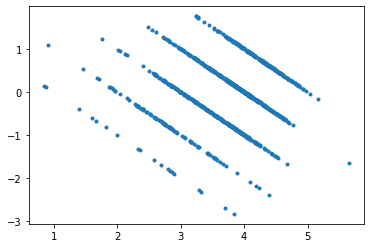

In [120]:
plt.plot(model_poly_linear.predict(X_poly), y - model_poly_linear.predict(X_poly), ".")

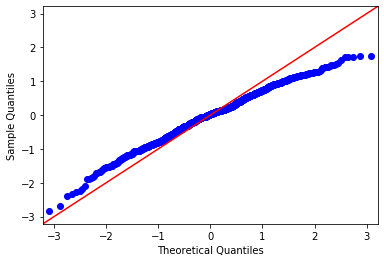

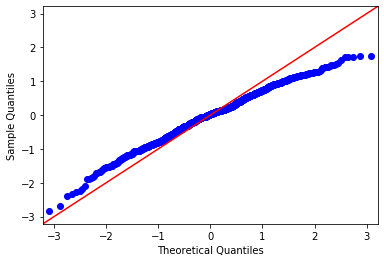

In [121]:
sm.qqplot(y - model_poly_linear.predict(X_poly), line="45")

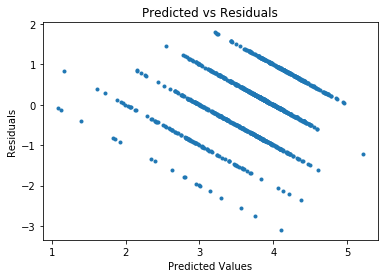

In [192]:
plt.plot(model_poly.predict(X_poly), y - model_poly.predict(X_poly), ".")
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig("plots/model_poly_pred_vs_resid.png")

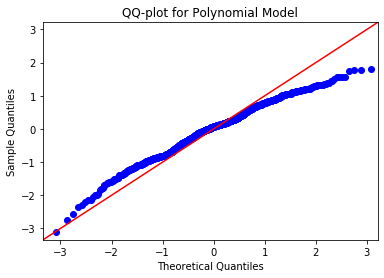

In [194]:
sm.qqplot(y - model_poly.predict(X_poly), line="45")
plt.title("QQ-plot for Polynomial Model")
plt.savefig("plots/model_poly_qqplot.png")

In [186]:
top5users

[30944, 12874, 52036, 12381, 28158]

In [187]:
top5ratings = (
    ratings
    .query("user_id in @top5users")
)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(top5ratings, reader)

In [188]:
cross_validate(SVD(), data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9835  0.9179  0.9804  0.8932  0.9014  0.9353  0.0389  
MAE (testset)     0.8057  0.7553  0.8034  0.7338  0.7131  0.7623  0.0370  
Fit time          0.05    0.04    0.03    0.03    0.03    0.04    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.98348363, 0.91790347, 0.98042553, 0.89318197, 0.90141167]),
 'test_mae': array([0.80571055, 0.75533496, 0.80343672, 0.73378891, 0.71305214]),
 'fit_time': (0.047609567642211914,
  0.0381314754486084,
  0.03276467323303223,
  0.0338902473449707,
  0.03374123573303223),
 'test_time': (0.001348733901977539,
  0.0012316703796386719,
  0.0010628700256347656,
  0.0010669231414794922,
  0.0010726451873779297)}

In [190]:
cross_validate(BaselineOnly(), data, cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9488  0.8332  0.9531  0.9426  0.9332  0.9222  0.0450  
MAE (testset)     0.7716  0.6911  0.7739  0.7791  0.7547  0.7541  0.0325  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.94879518, 0.83318877, 0.95309967, 0.94259321, 0.93317201]),
 'test_mae': array([0.77156383, 0.69107813, 0.77388672, 0.77906784, 0.75469869]),
 'fit_time': (0.0026671886444091797,
  0.003016233444213867,
  0.002294301986694336,
  0.0017635822296142578,
  0.004298210144042969),
 'test_time': (0.0010330677032470703,
  0.0008985996246337891,
  0.0010428428649902344,
  0.0008902549743652344,
  0.0031936168670654297)}